In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import datasets, layers, models
import pickle as pk
import tensorflow_datasets as tfds
from astropy.nddata import block_reduce
from astropy.convolution import Gaussian2DKernel, convolve
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers

%matplotlib inline

In [2]:
def normalize_map(imap):
    temp_map = np.zeros(imap.shape)
    for j in range(imap.shape[-1]):
        temp = (imap[...,j]-np.mean(imap[...,j]))/np.std(imap[...,j])
        temp_map[...,j] = temp
                                                        
    return temp_map

In [3]:
def comparison(test_data):
    train_predictions_baseline = model.predict(test_data)
    freezeout = 0
    for test_subset in test_data.take(1):
        test_predictions_baseline = model.predict(test_subset)

        freezeout = test_subset
        test_labels = test_subset[1].numpy()
    for i in range(len(test_labels)):
        if test_labels[i] != np.argmax(tf.nn.softmax(test_predictions_baseline), axis = 1)[i]:
            print('Sample {} misclasified with probability {}'.format(i, np.max(tf.nn.softmax(test_predictions_baseline), axis = 1)[i]))
    
    return freezeout

In [4]:
def make_model(model_type = 'simple_cnn', input_shape = (342,342,5), degree = 5):

    if model_type == 'simple_cnn':
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(2))
    elif model_type == 'resnet':
        model = tf.keras.applications.ResNet50(include_top=True,
        weights= None,
        input_shape = input_shape,
        classes = 2)
    elif model_type == 'pretrained':
        model = tf.keras.applications.ResNet50(include_top=False,
        weights= 'imagenet',
        input_shape = input_shape_rgb,
        classes = 2)
        
    elif model_type == 'inception_v2':
        base_model = tf.keras.applications.InceptionResNetV2(include_top = False,
                input_shape = input_shape,
                weights= 'imagenet'
                )
        base_model.trainable = False


    elif model_type == 'hyper':
        def train_test_model(hparams):
            model = models.Sequential()
            model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Conv2D(64, (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(hparams[HP_DROPOUT]))
            model.add(layers.Conv2D(64, (3, 3), activation='relu'))
            model.add(layers.Flatten())
            model.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
            model.add(layers.Dense(2))
            model.compile(
              optimizer=hparams[HP_OPTIMIZER],
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

            model.fit(train_dataset, epochs=10) 
            _, accuracy = model.evaluate(test_dataset)
            return accuracy


    elif model_type == 'test':
        model = models.Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', 
               input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(2)])

    elif model_type == 'deep_few_filters':
        model = models.Sequential()
        #model.add(layers.experimental.preprocessing.Rescaling(1./all_max, input_shape=input_shape))
        model.add(layers.Conv2D(2, (3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        j = 0
        for j in range(degree):
            model.add(layers.Conv2D(4, (3, 3), activation='relu'))
            model.add(layers.ZeroPadding2D((1,1)))
            #model.add(layers.MaxPooling2D((2, 2)))
            j +=1
        model.add(layers.Conv2D(8, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(2))
        
    elif model_type == 'dropout':
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.0001), activation='relu', input_shape=input_shape))
        layers.Dropout(0.5),
        model.add(layers.AveragePooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
        layers.Dropout(0.5),
        model.add(layers.AveragePooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
        layers.Dropout(0.5),
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(2))

    
    elif model_type == 'kosiba':
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
        for i in range(degree):
            model.add(layers.Conv2D(32, (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
        layers.Dropout(0.65)

        model.add(layers.Dense(2))
    model.summary()
    if model_type == 'kosiba':
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
              0.0001,
              decay_steps=348/10*1000,
              decay_rate=1e-6,
              staircase=False)
        opt = tf.keras.optimizers.SGD(
                learning_rate=0.01, momentum=0.9, nesterov = True, name='SGD')
        model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    else:
        model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

# With y

In [74]:
act = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-act/large-act_w_y.pk', 'rb'))
#redmapper = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/redmapper/redmapper_w_y.pk', 'rb'))
redmapper = None
neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))
print(act.shape, neg_im.shape)
if redmapper is None:
    tot = min(act.shape[0], neg_im.shape[0])
    train_size = int(0.7 * tot)
    val_size = int(0.15 * tot)
    test_size = int(0.15 * tot)
    
    train_pos = act[:train_size]
    val_pos = act[train_size:train_size + val_size]
    test_pos = act[train_size + val_size:]
    
    train_neg = neg_im[:train_size]
    val_neg = neg_im[train_size:train_size + val_size]
    test_neg = neg_im[train_size + val_size:]
     
    
else:
    train_act = act[:87]
    val_act = act[87:106]
    test_act = act[106:125]

    train_des = redmapper[:87]
    val_des= redmapper[87:106]
    test_des = redmapper[106:125]

    train_neg = neg_im[:174]
    val_neg = neg_im[174:212]
    test_neg = neg_im[212:250]

    train_pos = np.concatenate((train_act, train_des))
    val_pos = np.concatenate((val_act, val_des))
    test_pos = np.concatenate((test_act, test_des))

input_shape = train_pos.shape[1:]
print(input_shape)

(103, 399, 399, 6) (99, 399, 399, 6)
(399, 399, 6)


In [75]:
print(val_neg.shape,val_pos.shape)

(14, 399, 399, 6) (14, 399, 399, 6)


In [76]:
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

In [77]:
batch_size = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))


train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [28]:
print(train_images.shape)

(348, 342, 342, 6)


In [82]:
model = make_model('kosiba', input_shape = input_shape)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 397, 397, 64)      3520      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 198, 198, 64)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 196, 196, 32)      18464     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 46, 46, 32)      

In [83]:
history = model.fit(train_dataset, epochs=10, 
                    validation_data=val_dataset)

Train for 14 steps, validate for 3 steps
Epoch 1/10
14/14 [==============================] - 2s 120ms/step - loss: 0.8472 - accuracy: 0.4638 - val_loss: 0.8055 - val_accuracy: 0.3571
Epoch 2/10
14/14 [==============================] - 1s 67ms/step - loss: 0.6796 - accuracy: 0.6014 - val_loss: 0.8309 - val_accuracy: 0.5000
Epoch 3/10
14/14 [==============================] - 1s 62ms/step - loss: 0.5574 - accuracy: 0.7174 - val_loss: 1.2862 - val_accuracy: 0.5000
Epoch 4/10
14/14 [==============================] - 1s 65ms/step - loss: 0.4375 - accuracy: 0.7826 - val_loss: 1.3550 - val_accuracy: 0.3929
Epoch 5/10
14/14 [==============================] - 1s 72ms/step - loss: 0.5227 - accuracy: 0.8261 - val_loss: 1.1560 - val_accuracy: 0.6071
Epoch 6/10
14/14 [==============================] - 1s 73ms/step - loss: 0.4558 - accuracy: 0.8406 - val_loss: 1.2268 - val_accuracy: 0.5000
Epoch 7/10
14/14 [==============================] - 1s 61ms/step - loss: 0.3454 - accuracy: 0.8768 - val_loss: 0

4/4 - 0s - loss: 0.8807 - accuracy: 0.6389


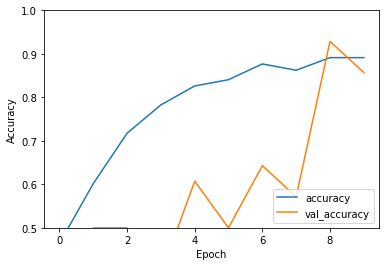

In [84]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

In [48]:
remainder_act = act[125:]
remainder_des = redmapper[125:]
remainder_randoms = neg_im[250:]

des_labels = np.array([1]*remainder_des.shape[0])
act_labels = np.array([1]*remainder_act.shape[0])
randoms_labels = np.array([0]*remainder_randoms.shape[0])

act_loss, act_acc = model.evaluate(x = remainder_act, y = act_labels, verbose=2)
des_loss, des_acc = model.evaluate(x = remainder_des, y = des_labels, verbose=2)
randoms_loss, randoms_acc = model.evaluate(x = remainder_randoms, y = randoms_labels, verbose=2)


194/194 - 0s - loss: 0.1581 - accuracy: 0.9691
285/285 - 1s - loss: 2.1841 - accuracy: 0.4351
38/38 - 0s - loss: 0.2802 - accuracy: 0.8684


1 0 93.67502927780151


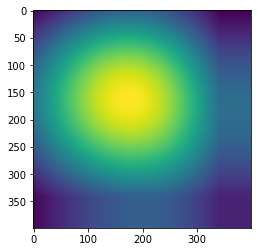

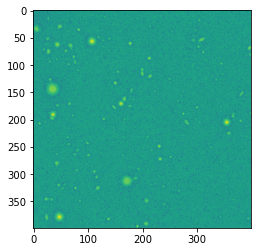

0 0 100.0


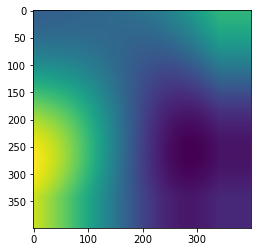

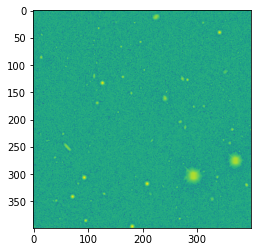

1 1 96.98230624198914


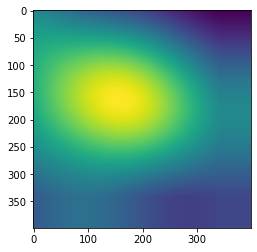

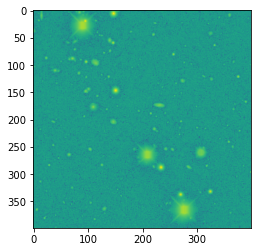

1 1 86.61288022994995


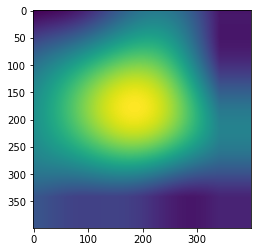

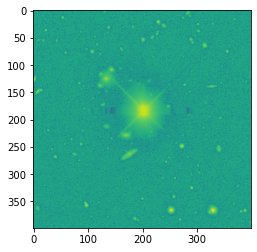

1 0 99.75869655609131


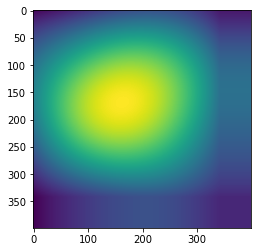

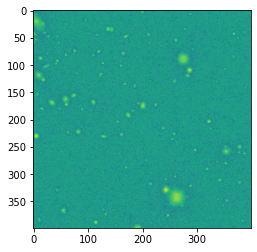

1 1 95.15041708946228


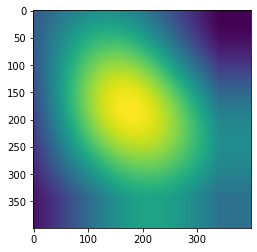

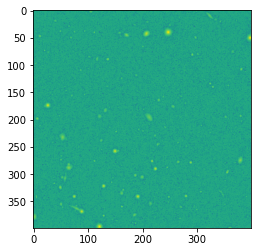

0 0 68.20404529571533


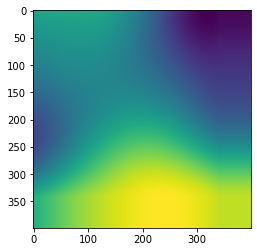

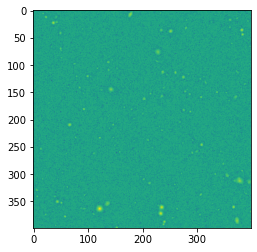

1 0 98.00573587417603


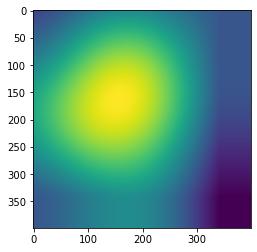

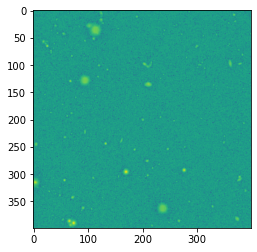

0 0 91.33726358413696


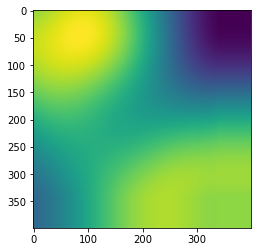

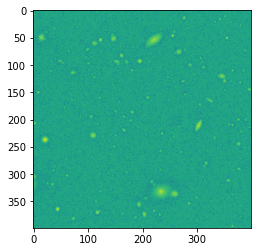

1 1 98.38215112686157


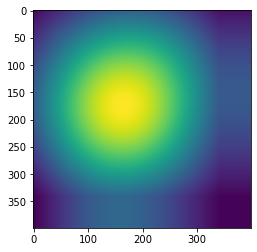

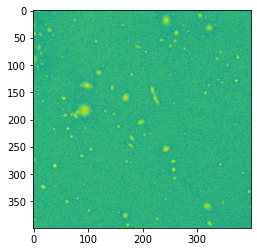

1 1 54.94647026062012


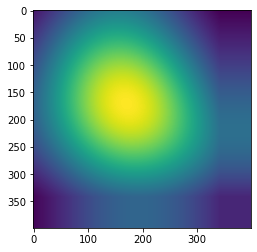

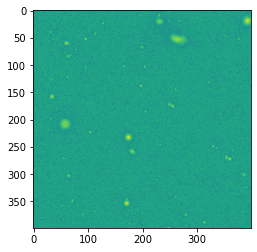

1 1 67.693692445755


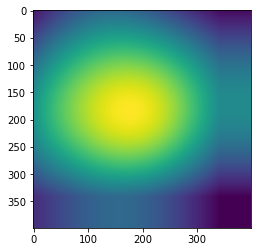

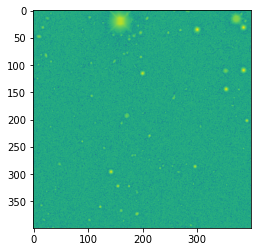

0 1 52.15402841567993


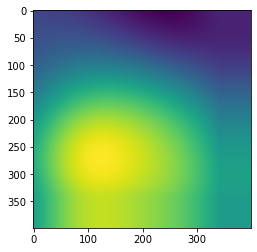

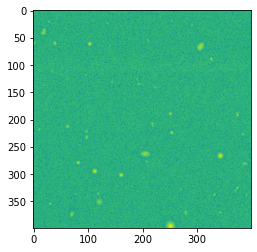

0 0 86.9497001171112


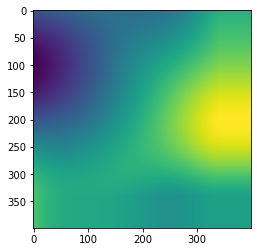

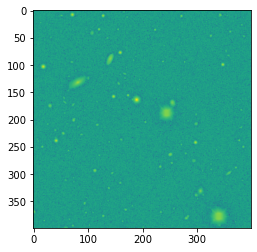

0 1 83.47449898719788


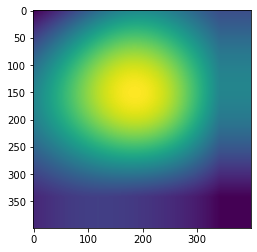

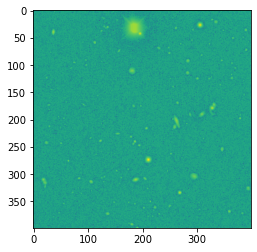

0 1 57.565778493881226


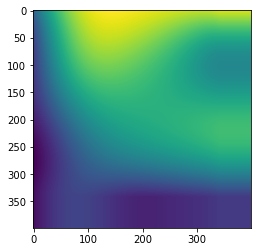

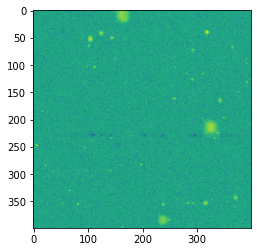

1 1 78.95338535308838


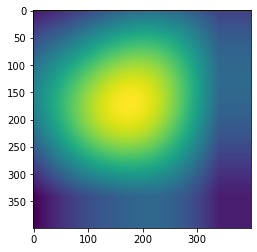

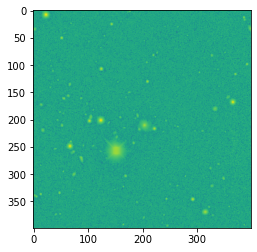

0 0 99.99995231628418


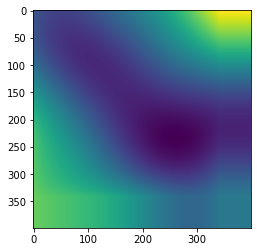

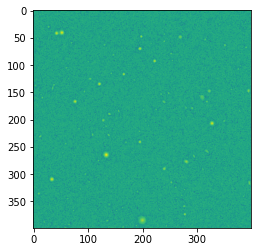

0 1 63.76853585243225


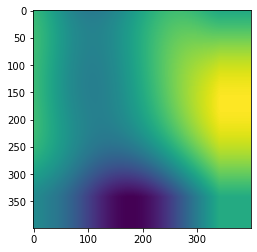

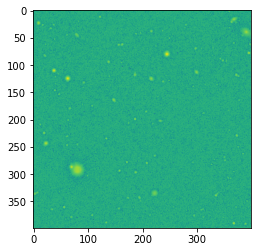

1 0 93.53534579277039


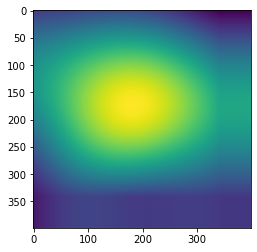

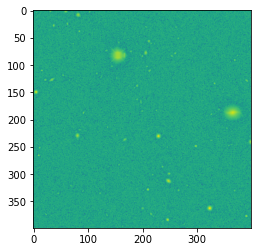

0 0 99.87016916275024


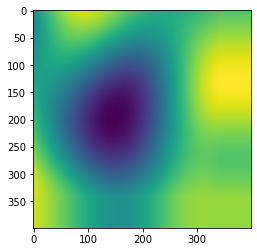

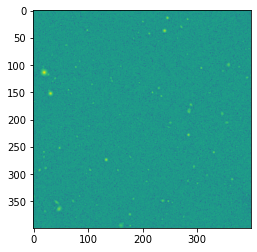

1 1 91.00189805030823


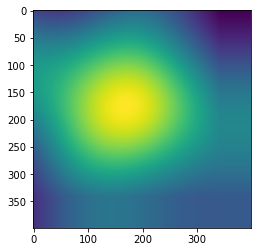

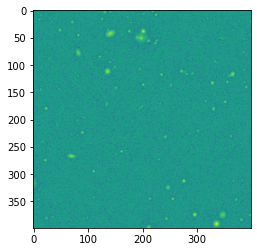

0 0 67.26107597351074


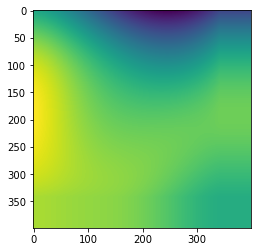

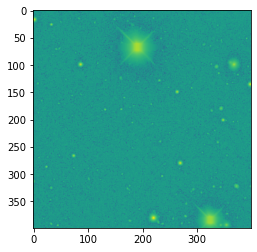

1 1 51.178330183029175


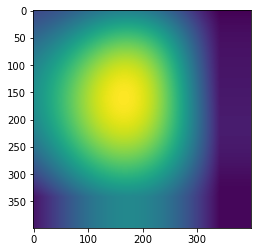

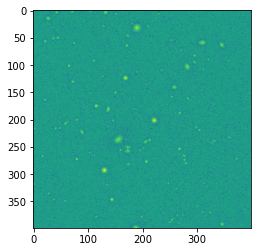

1 1 66.90713763237


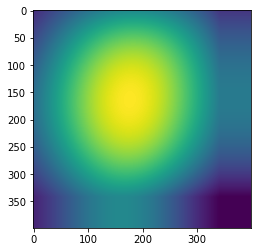

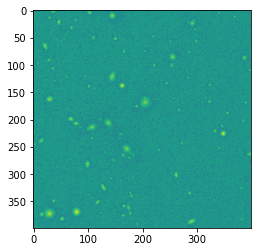

1 0 83.03418159484863


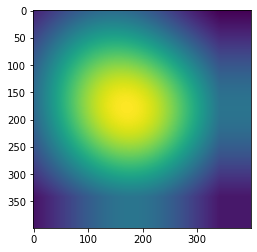

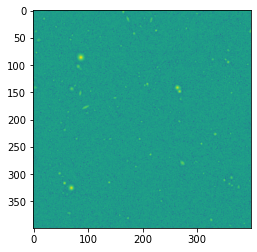

1 1 77.75440216064453


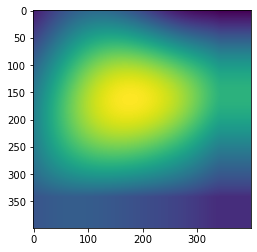

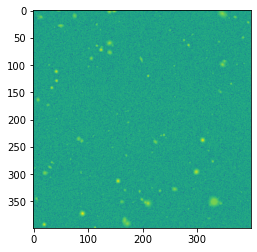

1 0 97.2727119922638


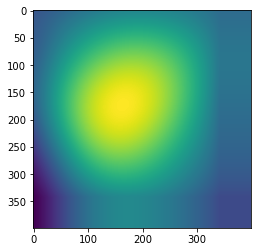

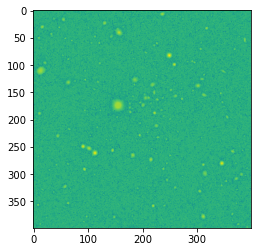

0 0 99.79423880577087


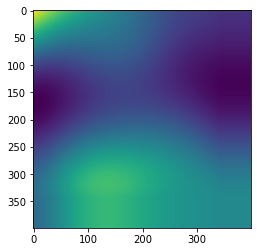

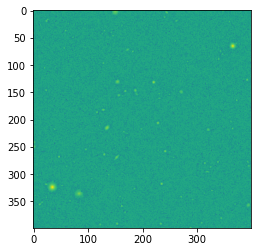

1 1 78.65619659423828


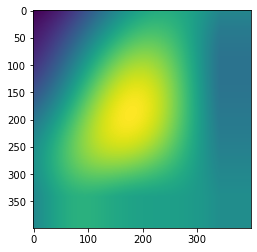

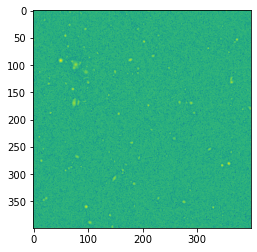

1 1 78.91683578491211


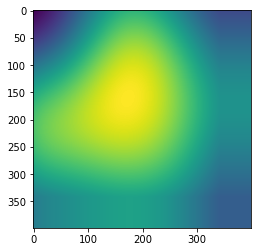

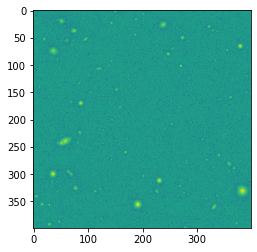

0 0 99.85803365707397


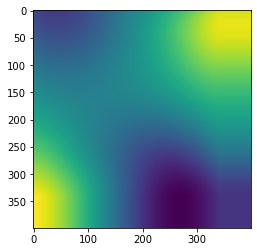

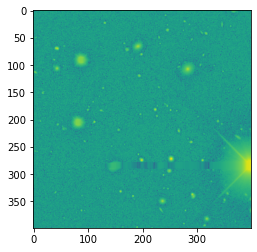

0 1 57.7436625957489


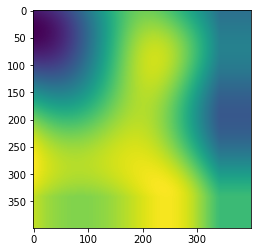

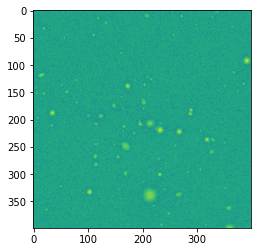

0 1 55.16693592071533


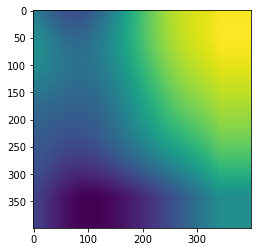

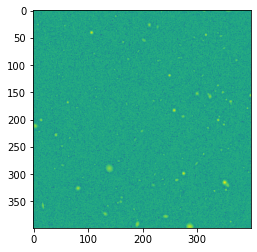

0 0 90.27882218360901


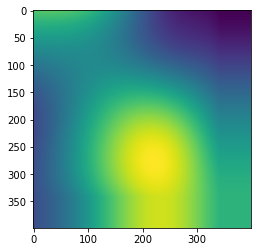

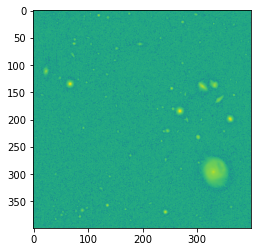

1 0 70.56341171264648


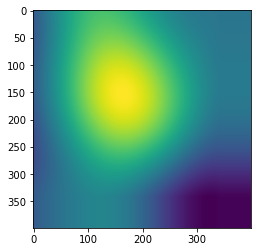

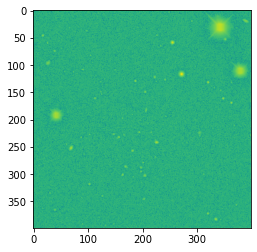

In [85]:
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        imap = thing[0][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        print(truth.numpy(), np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
        plt.imshow(imap[...,5])
        plt.show()
        plt.close()
        plt.imshow(np.log(np.abs(imap[...,2])))
        plt.show()
        plt.close()

1 0 99.99998807907104


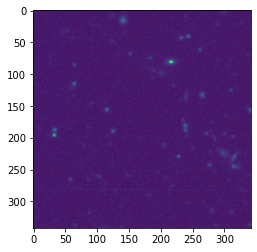

1 0 100.0


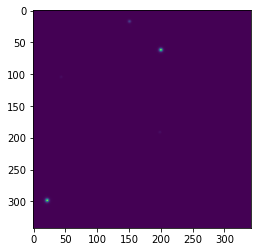

1 1 51.43756866455078


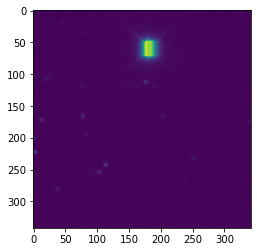

1 0 100.0


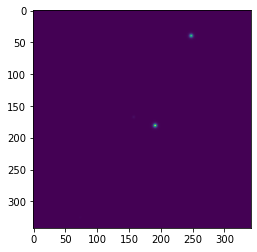

1 0 100.0


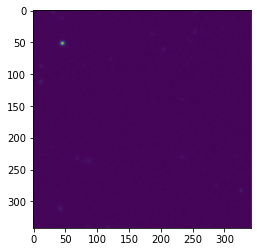

1 0 100.0


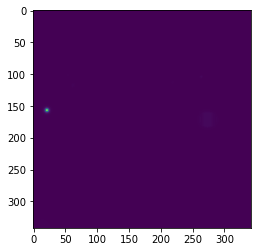

1 0 100.0


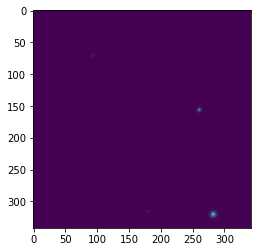

1 0 100.0


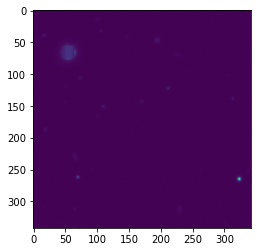

1 0 64.16348218917847


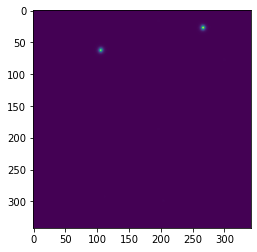

1 0 99.99686479568481


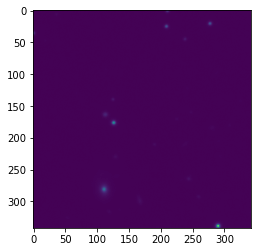

1 0 100.0


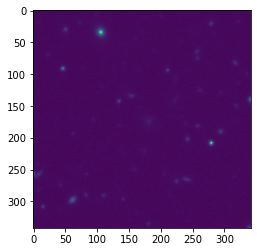

1 0 100.0


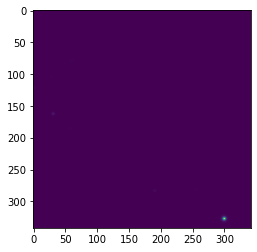

1 1 95.31106352806091


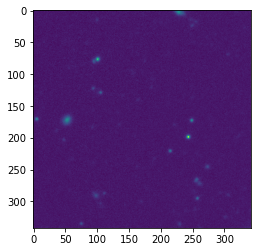

1 0 78.64860892295837


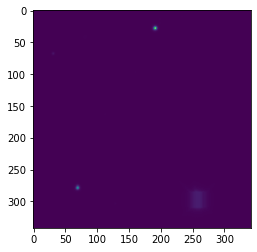

1 0 100.0


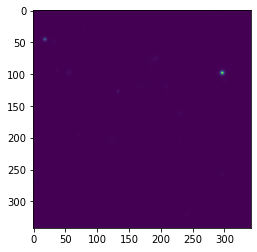

1 0 100.0


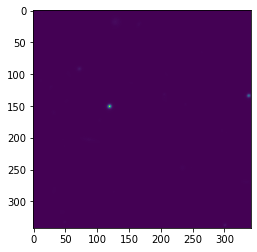

1 0 100.0


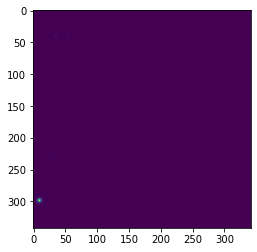

1 0 100.0


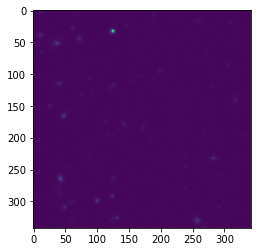

1 1 98.05677533149719


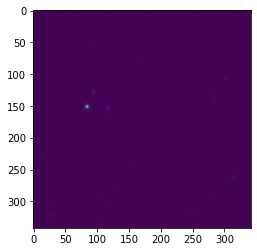

1 1 96.967613697052


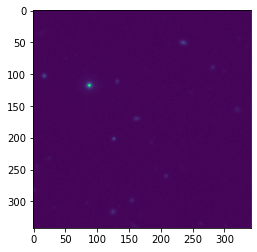

1 0 100.0


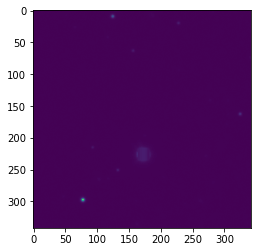

1 0 100.0


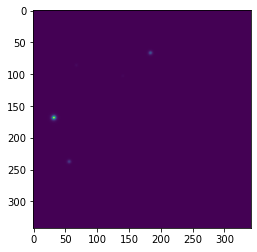

1 0 100.0


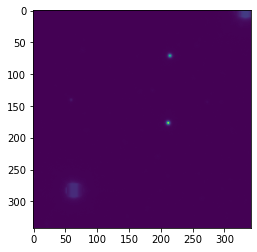

1 0 100.0


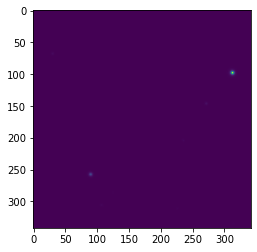

1 0 100.0


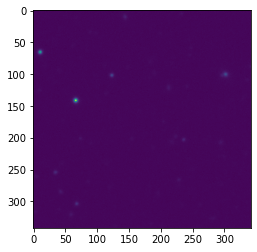

1 0 98.35042953491211


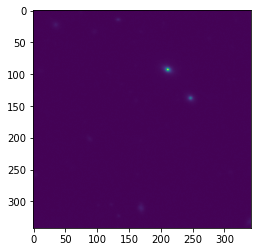

1 0 86.39724254608154


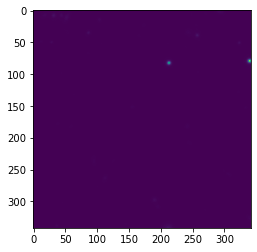

1 0 100.0


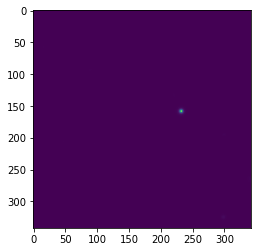

1 0 99.99998807907104


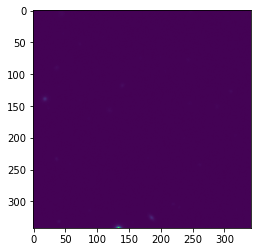

1 0 99.99998807907104


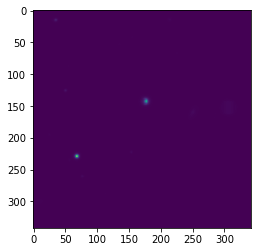

1 0 100.0


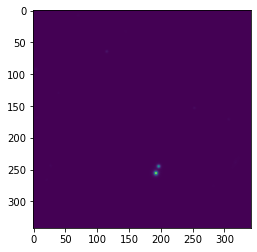

1 0 96.47384285926819


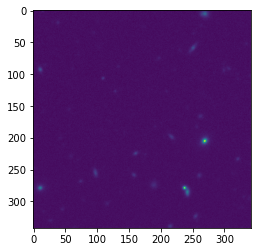

1 0 83.39550495147705


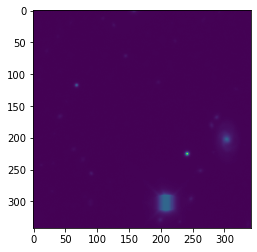

1 0 100.0


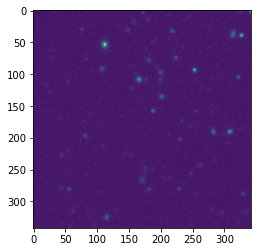

1 0 99.99897480010986


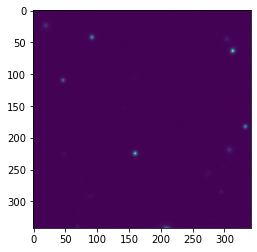

1 0 100.0


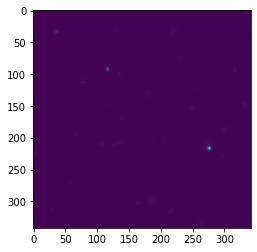

1 0 52.05683708190918


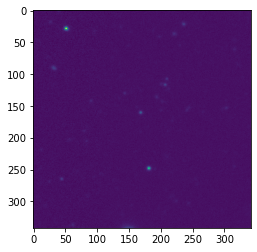

1 0 98.96408915519714


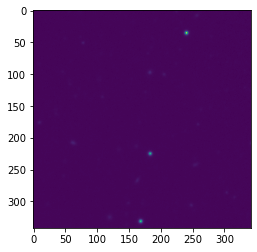

1 1 99.99985694885254


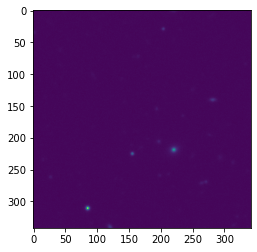

1 0 100.0


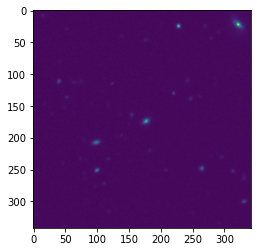

1 0 100.0


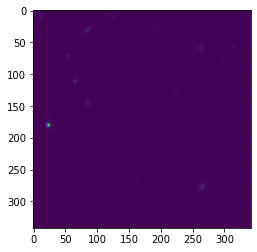

1 0 99.70290064811707


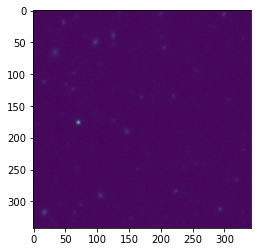

1 1 95.11218070983887


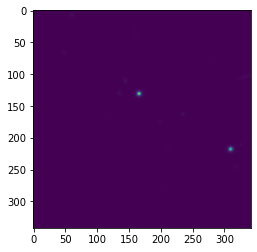

1 0 99.67082738876343


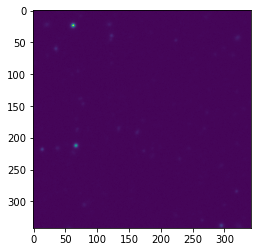

1 0 86.57522797584534


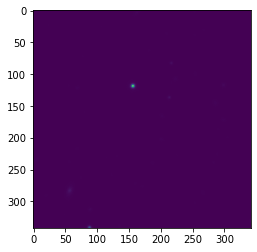

1 0 99.71680045127869


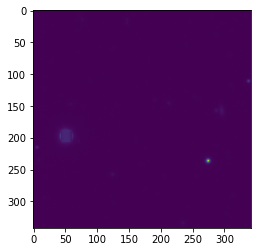

1 0 99.99845027923584


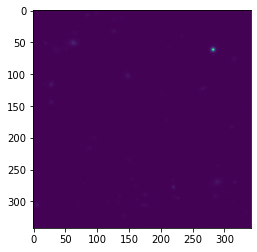

1 0 100.0


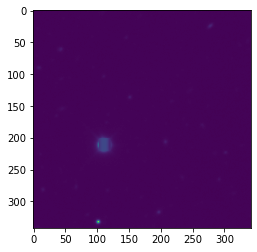

1 0 99.94445443153381


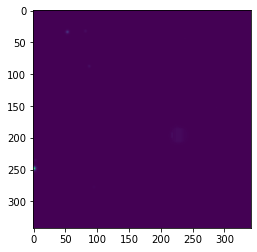

1 0 98.4714686870575


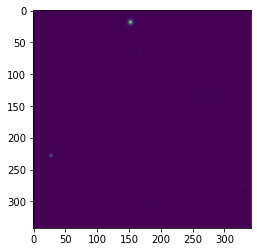

1 0 99.99873638153076


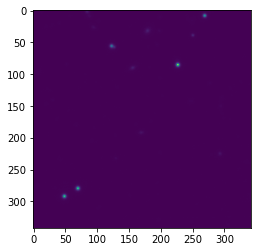

1 1 99.78725910186768


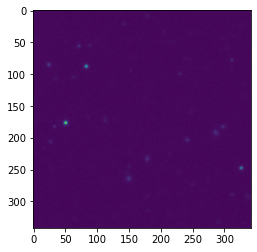

1 0 99.99991655349731


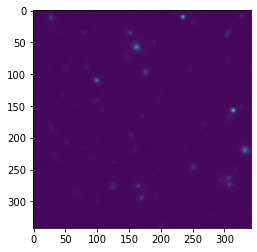

1 0 100.0


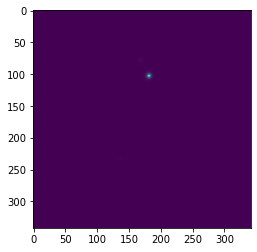

1 0 100.0


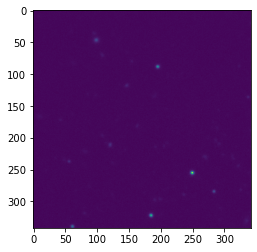

1 0 99.60144758224487


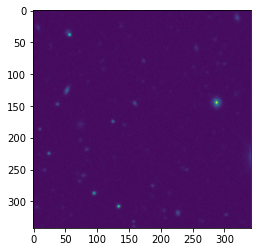

1 0 99.99992847442627


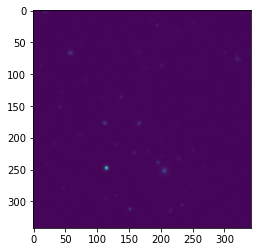

1 0 100.0


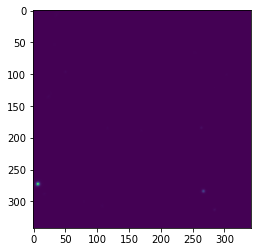

1 0 99.99908208847046


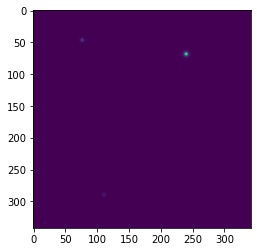

1 0 80.8050811290741


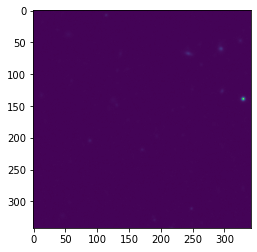

1 0 100.0


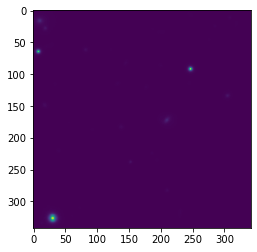

1 1 98.88655543327332


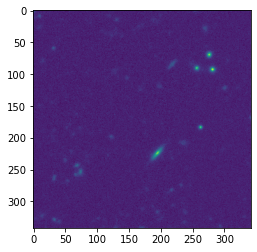

1 0 99.99997615814209


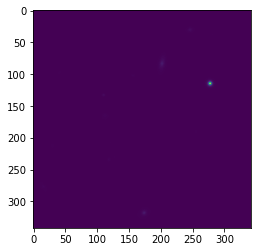

1 0 100.0


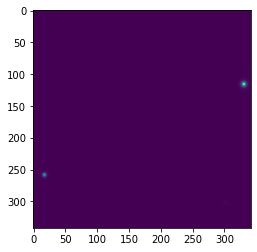

1 0 99.92913007736206


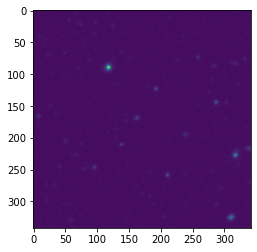

1 0 99.32674169540405


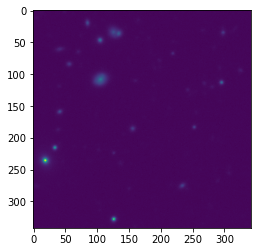

1 0 100.0


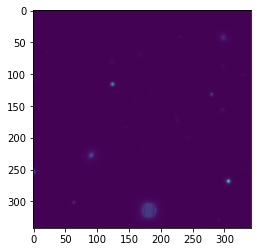

1 0 99.80545043945312


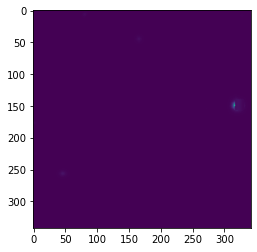

1 0 100.0


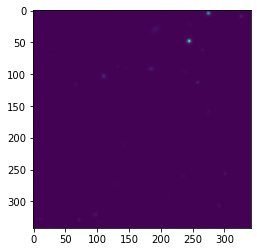

1 0 99.99998807907104


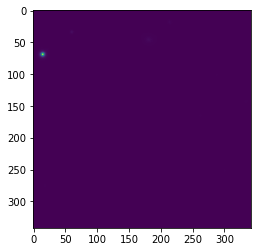

1 1 72.00316190719604


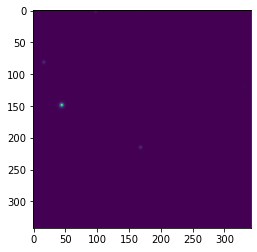

1 0 100.0


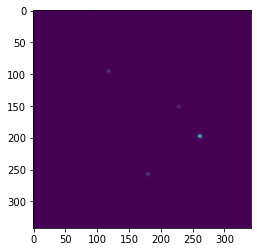

1 0 100.0


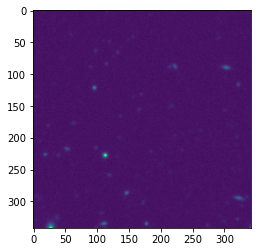

1 0 99.86159801483154


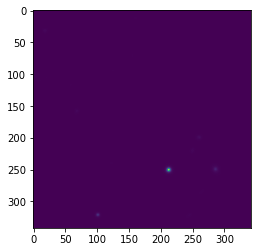

1 0 66.9795036315918


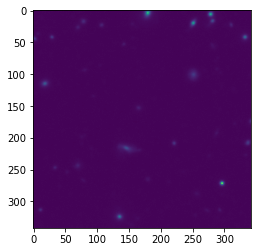

1 0 100.0


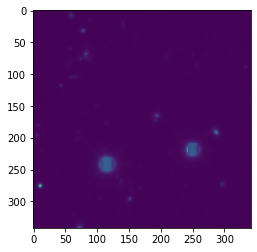

1 0 100.0


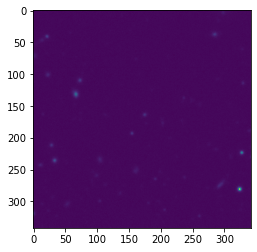

1 0 97.42761254310608


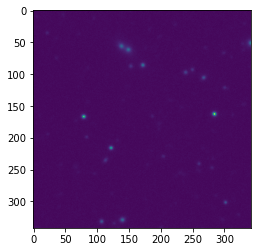

1 0 99.99579191207886


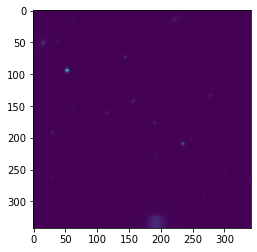

1 0 99.11995530128479


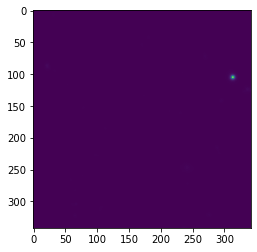

1 0 99.99964237213135


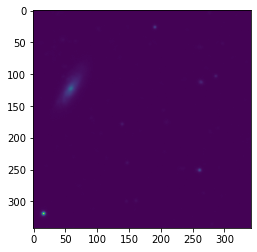

1 0 99.99924898147583


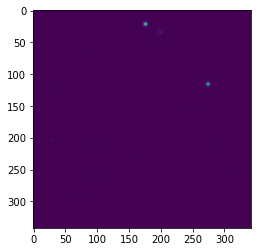

1 0 99.99933242797852


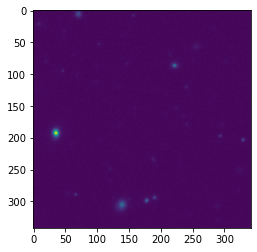

1 0 99.97076392173767


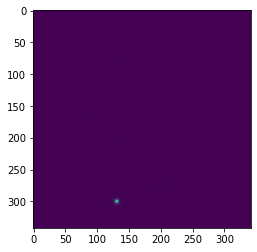

1 0 100.0


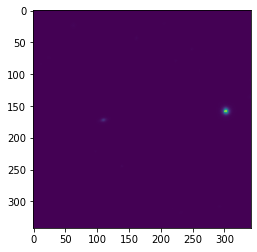

1 1 60.428351163864136


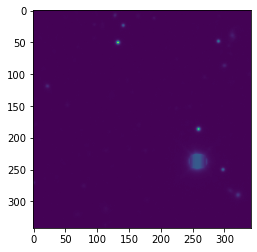

1 0 100.0


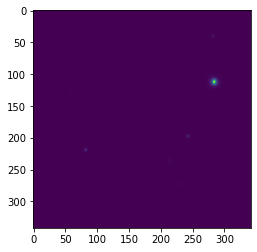

1 0 100.0


KeyboardInterrupt: 

In [246]:
for i in range(redmapper.shape[0]):
    truth = 1
    imap = redmapper[i]
    pred = model.predict(np.expand_dims(redmapper[i], axis = 0))
    print(truth, np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
    plt.imshow(imap[...,1])
    plt.show()
    plt.close()

# Redmapper only

In [13]:
pos_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-redmapper/large-redmapper_w_y.pk', 'rb'))
neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))

print(len(pos_im), len(neg_im))

136 99


In [32]:
pos_im, neg_im = pos_im[...,:5], neg_im[...,:5]

In [14]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)
    
train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]
    
train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

In [15]:
print(train_pos.shape, train_neg.shape)

(69, 399, 399, 6) (69, 399, 399, 6)


In [16]:
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

In [17]:
batch_size = 10

#data_augmentation = tf.keras.Sequential(
#    [
#        tf.keras.preprocessing.image.RandomFlip("horizontal"),
#        tf.keras.preprocessing.RandomRotation(0.1),
#        tf.keras.preprocessing.RandomZoom(0.1),
#        tf.keras.preprocessing.image.random_shift(0.01, 0.01),
#    ]
#)

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)

def prepare(ds, shuffle=False, augment=False):

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), )

  # Use buffered prefecting on all datasets
  return ds

In [18]:
batch_size = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [19]:
model = make_model('kosiba', input_shape = input_shape, degree = 4)


data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 397, 397, 64)      3520      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 198, 198, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)       

In [20]:
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=20, 
                    validation_data=val_dataset)

/home/r/rbond/jorlo/.conda/envs/gpu-ml-clusters/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (138, 399, 399, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/20
5/5 [==============================] - 19s 4s/step - loss: 0.8464 - accuracy: 0.4928 - val_loss: 0.6703 - val_accuracy: 0.7143
Epoch 2/20
5/5 [==============================] - 8s 2s/step - loss: 0.7591 - accuracy: 0.4928 - val_loss: 0.7403 - val_accuracy: 0.6071
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.7854 - accuracy: 0.5362 - val_loss: 0.7125 - val_accuracy: 0.6071
Epoch 4/20
5/5 [==============================] - 8s 2s/step - loss: 0.7408 - accuracy: 0.6014 - val_loss: 0.7200 - val_accuracy: 0.5714
Epoch 5/20
5/5 [==============================] - 8s 2s/step - loss: 0.7356 - accuracy: 0.5725 - val_loss: 0.7115 - val_accuracy: 0.5714
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 0.7038 - accuracy: 0.6087 - val_loss: 0.6922 - val_accuracy: 0.5714
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.7268 - accuracy: 0.5870 - val_loss: 0.691

7/7 - 0s - loss: 0.6616 - accuracy: 0.7536


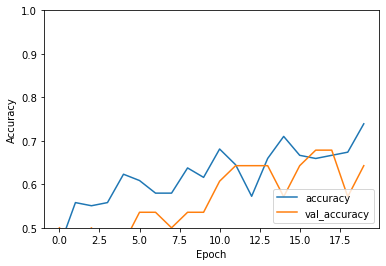

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

# Pretrained Redmapper

In [5]:
pos_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-redmapper/large-redmapper_w_y.pk', 'rb'))
#pos_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-act/large-act_w_y.pk', 'rb'))
neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))


In [6]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)
    
train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]
    
train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

In [7]:
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])


In [8]:
model = make_model('kosiba', input_shape = input_shape, degree = 4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 397, 397, 64)      3520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 198, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        9

In [9]:
checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/large_redmapper_w_y.ckpt"
model.load_weights(checkpoint_path)

In [82]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)


69/69 - 0s - loss: 1.7225 - accuracy: 0.7681


In [ ]:
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        imap = thing[0][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        print(truth.numpy(), np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
        plt.imshow(imap[...,5])
        plt.show()
        plt.close()
        plt.imshow(np.log(np.abs(imap[...,2])))
        plt.show()
        plt.close()

In [36]:
model.layers[0].get_weights()[0].shape

(3, 3, 6, 64)

In [83]:
for layer in model.layers:
    if layer.name[0:6] == 'conv2d':
        temp = layer.get_weights()
        temp[0][...,:5,:] = np.zeros(temp[0][...,:5,:].shape)
        layer.set_weights(temp)

In [84]:
loss, acc_test = model.evaluate(test_images, test_labels, verbose=2)
loss, acc_val = model.evaluate(val_images, val_labels, verbose=2)
loss, acc_train = model.evaluate(train_images, train_labels, verbose=2)


69/69 - 0s - loss: 4.0786 - accuracy: 0.4638
28/28 - 0s - loss: 3.0478 - accuracy: 0.6429
138/138 - 0s - loss: 2.9386 - accuracy: 0.6304


In [1]:
#test change